In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
root_dir = '/content/drive/MyDrive/credit-now' if os.getcwd().split('/')[-1] != 'credit-now' else './'
os.chdir(root_dir)

Mounted at /content/drive


In [ ]:
# !pip uninstall -y typing # this should avoid  AttributeError: type object 'Callable' has no attribute '_abc_registry'
# !pip install  "git+https://github.com/dreamquark-ai/tabnet.git@develop#egg=pytorch_tabnet" --upgrade

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from tensorflow.keras import models, layers, utils
import torch

import credit_data

In [37]:
train_data, test_data, train_label, test_label = credit_data.load_data(name='train_cat', encoding=False)
print(train_data.shape, test_data.shape, train_label.shape, test_label.shape)
train_data.head()

(15906, 17) (6818, 17) (15906, 1) (6818, 1)


,gender,car,reality,child_num,income_range,income_type,edu_type,family_type,house_type,age_range,employed_range,work_phone,phone,email,occyp_type,family_size,begin_range
419,1,1,0,0,2,0,1,0,0,2,2,1,1,1,4,2,3
1082,0,0,1,0,0,2,0,0,3,5,0,0,0,0,0,2,1
10725,0,1,0,1,2,1,0,0,0,4,5,0,0,0,12,3,2
20755,1,1,0,0,1,1,0,0,0,4,1,0,1,0,3,2,3
8348,0,1,1,1,0,0,0,0,0,4,0,1,1,0,5,3,9


In [38]:
columns = train_data.columns.tolist()
categorical_columns = list()
# numeric_columns = ['income_total','age','employed_year','begin_year']
# categorical_columns = [columns for columns in columns if columns not in numeric_columns]
cat_idxs = [i for i, column in enumerate(columns) if column in categorical_columns]
cat_dims = [train_data[column].max() for column in columns if column in categorical_columns]

In [ ]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                cat_idxs=cat_idxs,
                                cat_dims=cat_dims,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50,"gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax',
                                lambda_sparse=0)

In [41]:
max_epochs = 1000
clf.fit(
    X_train=np.array(train_data), y_train=train_label,
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.93767 |  0:00:00s
epoch 1  | loss: 0.87715 |  0:00:01s
epoch 2  | loss: 0.86388 |  0:00:01s
epoch 3  | loss: 0.85464 |  0:00:02s
epoch 4  | loss: 0.84735 |  0:00:02s
epoch 5  | loss: 0.84398 |  0:00:03s
epoch 6  | loss: 0.84215 |  0:00:03s
epoch 7  | loss: 0.8417  |  0:00:04s
epoch 8  | loss: 0.84225 |  0:00:04s
epoch 9  | loss: 0.84028 |  0:00:05s
epoch 10 | loss: 0.83994 |  0:00:05s
epoch 11 | loss: 0.83809 |  0:00:06s
epoch 12 | loss: 0.83758 |  0:00:06s
epoch 13 | loss: 0.836   |  0:00:07s
epoch 14 | loss: 0.83799 |  0:00:07s
epoch 15 | loss: 0.83441 |  0:00:08s
epoch 16 | loss: 0.83347 |  0:00:08s
epoch 17 | loss: 0.83159 |  0:00:09s
epoch 18 | loss: 0.83084 |  0:00:09s
epoch 19 | loss: 0.82798 |  0:00:10s
epoch 20 | loss: 0.82848 |  0:00:10s
epoch 21 | loss: 0.82675 |  0:00:11s
epoch 22 | loss: 0.82463 |  0:00:11s
epoch 23 | loss: 0.82518 |  0:00:12s
epoch 24 | loss: 0.82267 |  0:00:12s
epoch 25 | loss: 0.82145 |  0:00:13s
epoch 26 | loss: 0.82117 |  0:00:13s
e

In [46]:
feature_importance = clf.feature_importances_
feature_importance

array([0.0693487 , 0.06125969, 0.03272165, 0.04921308, 0.03807884,
       0.0351822 , 0.09250372, 0.02434113, 0.01741981, 0.01221023,
       0.01285816, 0.06782794, 0.13041049, 0.04141373, 0.04164415,
       0.08876082, 0.18480567])

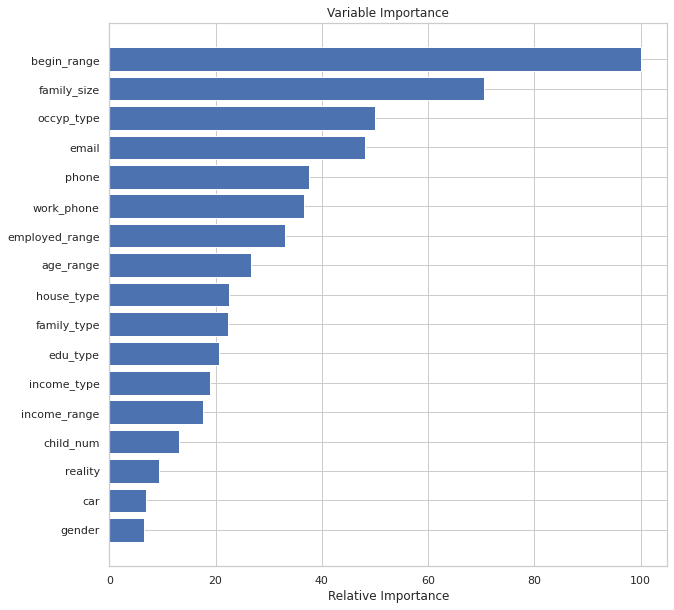

In [47]:
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize = (10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('graphs/feature_importances_tabnet')
plt.show()

In [75]:
pred_train = np.array(clf.predict(np.array(train_data)),dtype=int).transpose()
pred_test = np.array(clf.predict(np.array(test_data)),dtype=int).transpose()
print('train accuracy:', accuracy_score(train_label, pred_train))
print('test accuracy:', accuracy_score(test_label, pred_test))

train accuracy: 0.7452533635106249
test accuracy: 0.6534174244646523


In [ ]:
clf.save_model('models/model_tabnet')

In [ ]:
loaded_clf = TabNetMultiTaskClassifier()
loaded_clf.load_model('models/model_tabnet.zip')